# Variable和Function
在本节中，主要介绍的是pytorch中构建计算图的方式，主要包括以下内容：

1. pytorch如何构建计算图（`Variable`与`Function`类）
2. `Variable`与`Tensor`的差别
3. 动态图机制是如何进行的（`Variable`与`Function`如何建立计算图）
## pytorch如何构建计算图（`Variable`与`Function`）
* 一般一个神经网络都可以用一个有向无环图图来表示计算过程，在pytorch中也是构建计算图来实现forward计算以及backward梯度计算。
* 计算图由节点和边组成。
* 计算图中边相当于一种函数变换或者说运算，节点表示参与运算的数据。边上两端的两个节点中，一个为函数的输入数据，一个为函数的输出数据。
* 而`Variable`就相当于计算图中的节点。
* `Function`就相当于是计算图中的边，它实现了对一个输入`Variable`变换为另一个输出的`Variable`
* 因此，`Variable`需要保存forward时计算的激活值。这个值是一个`Tensor`，可以通过`.data`来得到这个Variable所保存的forward时的计算值。
* 同时反向传导时，一个`Variable`还需要保存其梯度。该梯度也是一个`Variable`，可以通过`.grad`来得到。

## Variable与Tensor差别
* `Tensor`只是一个类似`Numpy array`的数据格式，它可以进行多种运行，但无法构建计算图
* `Variable`不仅封装了`Tensor`作为对应的激活值，还保存了产生这个`Variable`的`Function`（即计算图中的边），可以通过`.creator`来看是哪个Function输出了这个Variable
* 在forward时，`Variable`和`Function`构建一个计算图。只有得到了计算图，构建了`Variable`与`Function`与Variable的输入输出关系，才能在backward时，计算各个节点的梯度。
* `Variable`可以进行`Tensor`的大部分计算
* 对`Variable`使用`.backward()`方法，可以得到该Variable之前计算图所有Variable的梯度

## 动态图机制是如何进行的（Variable和Function的关系）
* Variable与Function组成了计算图
* Function是在每次对Variable进行运算生成的，表示的是该次运算
* 动态图是在每次forward时动态生成的。具体说，假如有Variable x，Function \*。他们需要进行运算y = x \* x，则在运算过程时已经得到一个动态图，该动态图输入是x，输出是y，y的`.creator`是\*
* 一次forward过程将有多个Function连接各个Variable，Function输出的Variable将保存该Function的引用（即.creator），从而组成计算图
* 在backward时，将利用这些关系得到backward的值

## Variable基本操作

In [1]:
from torch.autograd import Variable, Function
import torch

In [2]:
# 生成Variable
x = Variable(torch.ones(2, 2), requires_grad=True) # requires_grad表示在backward是否计算其梯度
print(x)

print('-----------------------')

# 查看Variable的属性.data, .grad, .creator
print(x.data)    # Variable保存的值
print(x.grad)    # 由于目前还未进行.backward()运算，因此不存在梯度
print(x.creator) # 对于手动申明的Variable，不存在creator，即在计算图中，该Variable不存在父节点

print('-----------------------')

# Variable进行运算
y = x + 2
print(y)
print(y.creator) # y是存在x这个父节点，并且通过'+'这个Function进行连接，因此y.creator是该运算

# 查看Variable对应的creator

Variable containing:
 1  1
 1  1
[torch.FloatTensor of size 2x2]

-----------------------

 1  1
 1  1
[torch.FloatTensor of size 2x2]

None
None
-----------------------
Variable containing:
 3  3
 3  3
[torch.FloatTensor of size 2x2]



## Variable计算梯度

In [5]:
# 进行backward

z.backward() # 注意这里等价于z.backward(torch.Tensor([1.0]))，参数表示的是后面的输出对Variable z的梯度
print(x.grad)
print(y.grad) # 此时y.grad为None，因为backward()只求图中叶子的梯度（即无父节点）,如果需要对y求梯度，则可以使用`register_hook`

Variable containing:
 1
[torch.FloatTensor of size 1]

None


## Variable的requires_grad参数与volatile参数
* 在创建一个Variable是，有两个bool型参数可供选择，一个是requires_grad，一个是Volatile
* requires_grad不是十分对该Var进行计算梯度，一般在finetune是可以用来固定某些层的参数，减少计算。只要有一个叶节点是True，其后续的节点都是True
* volatile=True，一般用在训练好网络，只进行inference操作时使用，其不建立Variable与Function的关系。只要有一个叶子节点是True，其后节点都是True


## 例子

In [13]:
from sklearn.datasets import load_boston
from sklearn import preprocessing
from torch.autograd import Variable

# dtype = torch.FloatTensor
dtype = torch.cuda.FloatTensor
X, y = load_boston(return_X_y=True)
X = preprocessing.scale(X[:100,:])
y = preprocessing.scale(y[:100].reshape(-1, 1))

data_size, D_input, D_output, D_hidden = X.shape[0], X.shape[1], 1, 50
X = Variable(torch.Tensor(X).type(dtype), requires_grad=False)
y = Variable(torch.Tensor(y).type(dtype), requires_grad=False)
w1 = Variable(torch.randn(D_input, D_hidden).type(dtype), requires_grad=True)
w2 = Variable(torch.randn(D_hidden, D_output).type(dtype), requires_grad=True)

lr = 1e-5
epoch = 200000
for i in range(epoch):
    
    # forward
    h = torch.mm(X, w1)
    h_relu = h.clamp(min=0)
    y_pred = torch.mm(h_relu, w2)
    loss = (y_pred - y).pow(2).sum()
    if i % 10000 == 0:
        print('epoch: {} loss: {}'.format(i, loss.data[0]))    # 使用loss.data[0]，可以输出Tensor的值，而不是Tensor信息
    
    # backward 我们直接使用Variable.backward()，就能根据forward构建的计算图进行反向传播
    loss.backward()
      

    w1.data -= lr * w1.grad.data                       
    w2.data -= lr * w2.grad.data

    w1.grad.data.zero_()
    w2.grad.data.zero_()

torch.Size([100, 13]) epoch: 0 loss: 15255.53125
epoch: 10000 loss: 6.21921396255
epoch: 20000 loss: 2.53848791122
epoch: 30000 loss: 1.52961266041
epoch: 40000 loss: 1.08377480507
epoch: 50000 loss: 0.817189872265
epoch: 60000 loss: 0.640373170376


KeyboardInterrupt: 

## 可视化计算图

Variable containing:
 1
[torch.FloatTensor of size 1]

Variable containing:
 2
[torch.FloatTensor of size 1]



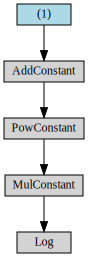

In [4]:
from utils.visualizer import make_dot
from torch.autograd import Variable
import torch

# 生成一个计算图y = 0.5*(x + 1)^2;  z = ln(y)
x = Variable(torch.ones([1]), requires_grad=True)
y = 0.5 * (x + 1).pow(2)
z = torch.log(y)

print(x)
print(y)
g = make_dot(z)
g